# Regression
Predict the final goals scored per each team.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile

tf.compat.v1.disable_eager_execution()

In [2]:
#pip install git+https://github.com/tensorflow/docs

## Data Preprocessing
    1. Normalization
    2. Data encoding: The goals [0,10] => [-1,1]. If Goal > 10 => 1

In [3]:
df02 = pd.read_csv('https://raw.githubusercontent.com/Khaledjallouli/project/master/data/data_regression_goals/sliding02_goals.csv', sep=',', index_col=0)

In [4]:
df02

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,1,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,2,2,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,1,2,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,2,1,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,3,0,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,1,5.00,3.80,1.70,4,2,4,10,12,80,43,117,60,2,4,4,10,21,119,58,112,65
7029,4,2,2.00,3.60,3.70,3,2,5,9,21,89,47,92,46,1,4,5,7,21,104,55,63,26
7030,4,1,1.80,3.75,4.50,3,3,4,8,8,122,59,92,50,5,2,3,15,9,84,43,118,56
7031,3,1,1.33,5.25,9.00,2,3,5,12,14,124,62,99,50,3,3,4,11,17,103,53,122,54


In [5]:
byhomegoal = df02.groupby('home_team_goal')
byhomegoal.size().sort_values(ascending=False)

home_team_goal
1     2251
2     1732
0     1589
3      885
4      378
5      132
6       43
7       13
8        7
9        2
10       1
dtype: int64

In [6]:
byawaygoal = df02.groupby('away_team_goal')
byawaygoal.size().sort_values(ascending=False)

away_team_goal
1    2381
0    2362
2    1401
3     613
4     193
5      52
6      23
8       5
7       2
9       1
dtype: int64

### =>The two previous cells show that we can keep 6 classes: [0.5].


In [7]:
def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['home_team_goal','away_team_goal']).values
    y = dataframe[['home_team_goal','away_team_goal']].values
    return X,y

In [8]:
def encode(i):
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
    }
    # 1 be assigned as default value of passed argument (if goals > 5)
    #return switcher.get(i, 1)
    return switcher.get(i, 5)

def decode(i):
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
    }
    #return switcher.get(i, "ERROR! Use Encode Before!")
    return switcher.get(i, "ERROR! Use Encode Before!")

In [9]:
def normalize(dataframe):
    column_names_to_not_normalize = ['home_team_goal','away_team_goal']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    x_scaled = preprocessing.normalize(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp
    
    dataframe['home_team_goal'] = dataframe.apply(lambda row: encode(row['home_team_goal']), axis=1)
    dataframe['away_team_goal'] = dataframe.apply(lambda row: encode(row['away_team_goal']), axis=1)
    
    return dataframe

In [10]:
n02 = normalize(df02)

train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')

labels = n02.iloc[:,0:2]
train = n02.iloc[:,2:]


train_X02,train_y02 = get_X_and_y(train02)
labels_train = n02.iloc[:,0:2]

test_X02,test_y02 = get_X_and_y(test02)

6329 train examples
704 test examples


In [11]:
train

,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039230,0.057061,0.488587,0.238944,0.417260,0.189015,0.028531,0.007133,0.000000,0.053495,0.021398,0.574178,0.278173,0.256775,0.106990
1,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059110,0.495044,0.236439,0.557848,0.284465,0.011083,0.011083,0.014777,0.040638,0.066498,0.384213,0.162552,0.321409,0.132997
2,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451585,0.218266,0.466638,0.210740,0.007526,0.007526,0.022579,0.041395,0.056448,0.504270,0.222029,0.376321,0.173108
3,0.010289,0.010289,0.007281,0.015829,0.006332,0.009497,0.069647,0.037989,0.560339,0.259592,0.234266,0.117133,0.018995,0.009497,0.003166,0.060149,0.025326,0.535013,0.300747,0.357730,0.183614
4,0.004077,0.020384,0.064551,0.023782,0.006795,0.003397,0.050961,0.027179,0.546982,0.244613,0.251408,0.105320,0.010192,0.006795,0.016987,0.033974,0.057756,0.485829,0.234421,0.455252,0.234421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,0.020289,0.015420,0.006898,0.016231,0.008116,0.016231,0.040578,0.048694,0.324626,0.174487,0.474766,0.243470,0.008116,0.016231,0.016231,0.040578,0.085214,0.482881,0.235354,0.454477,0.263759
7029,0.009960,0.017929,0.018427,0.014941,0.009960,0.024901,0.044822,0.104584,0.443238,0.234070,0.458179,0.229089,0.004980,0.019921,0.024901,0.034861,0.104584,0.517941,0.273911,0.313753,0.129485
7030,0.007617,0.015870,0.019044,0.012696,0.012696,0.016928,0.033855,0.033855,0.516293,0.249683,0.389336,0.211596,0.021160,0.008464,0.012696,0.063479,0.038087,0.355481,0.181972,0.499366,0.236987
7031,0.005271,0.020806,0.035667,0.007926,0.011889,0.019815,0.047556,0.055483,0.491416,0.245708,0.392341,0.198152,0.011889,0.011889,0.015852,0.043593,0.067372,0.408193,0.210041,0.483490,0.214004


In [12]:
n02

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,1,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039230,0.057061,0.488587,0.238944,0.417260,0.189015,0.028531,0.007133,0.000000,0.053495,0.021398,0.574178,0.278173,0.256775,0.106990
1,2,2,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059110,0.495044,0.236439,0.557848,0.284465,0.011083,0.011083,0.014777,0.040638,0.066498,0.384213,0.162552,0.321409,0.132997
2,1,2,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451585,0.218266,0.466638,0.210740,0.007526,0.007526,0.022579,0.041395,0.056448,0.504270,0.222029,0.376321,0.173108
3,2,1,0.010289,0.010289,0.007281,0.015829,0.006332,0.009497,0.069647,0.037989,0.560339,0.259592,0.234266,0.117133,0.018995,0.009497,0.003166,0.060149,0.025326,0.535013,0.300747,0.357730,0.183614
4,3,0,0.004077,0.020384,0.064551,0.023782,0.006795,0.003397,0.050961,0.027179,0.546982,0.244613,0.251408,0.105320,0.010192,0.006795,0.016987,0.033974,0.057756,0.485829,0.234421,0.455252,0.234421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,1,0.020289,0.015420,0.006898,0.016231,0.008116,0.016231,0.040578,0.048694,0.324626,0.174487,0.474766,0.243470,0.008116,0.016231,0.016231,0.040578,0.085214,0.482881,0.235354,0.454477,0.263759
7029,4,2,0.009960,0.017929,0.018427,0.014941,0.009960,0.024901,0.044822,0.104584,0.443238,0.234070,0.458179,0.229089,0.004980,0.019921,0.024901,0.034861,0.104584,0.517941,0.273911,0.313753,0.129485
7030,4,1,0.007617,0.015870,0.019044,0.012696,0.012696,0.016928,0.033855,0.033855,0.516293,0.249683,0.389336,0.211596,0.021160,0.008464,0.012696,0.063479,0.038087,0.355481,0.181972,0.499366,0.236987
7031,3,1,0.005271,0.020806,0.035667,0.007926,0.011889,0.019815,0.047556,0.055483,0.491416,0.245708,0.392341,0.198152,0.011889,0.011889,0.015852,0.043593,0.067372,0.408193,0.210041,0.483490,0.214004


In [13]:
# verif the classes
byhomegoal = df02.groupby('home_team_goal')
byhomegoal.size().sort_values(ascending=False)

home_team_goal
1    2251
2    1732
0    1589
3     885
4     378
5     198
dtype: int64

In [14]:
byawaygoal = df02.groupby('away_team_goal')
byawaygoal.size().sort_values(ascending=False)

away_team_goal
1    2381
0    2362
2    1401
3     613
4     193
5      83
dtype: int64

In [15]:
def round_pred(val):
    if val <=1 and val > 0.67:
        return 1
    elif val <=0.67 and val >0.33:
        return 0.60
    elif val <= 0.33 and val > 0:
        return 0.20
    elif val <= 0 and val > -0.33:
        return -0.20
    elif val<=-0.33 and val> -0.67:
        return -0.60
    else:
        return -1

### Build the model

https://www.tensorflow.org/tutorials/keras/regression
The mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions – i.e. an estimate of how accurate the neural network is in predicting the test data. We can see that with the validation_split set to 0.2, 80% of the training data is used to test the model, while the remaining 20% is used for testing purposes.

In [16]:
train02, test02 = train_test_split(train, test_size=0.1, shuffle=False)
trainlabels02, testlabels02 = train_test_split(labels, test_size=0.1, shuffle=False)

yout1 = testlabels02.iloc[:,0]
yout2 = testlabels02.iloc[:,1]

x = train02
y = testlabels02
y1 = trainlabels02.iloc[:,0]
y2 = trainlabels02.iloc[:,1]

y = y.astype(int)
y1 = y1.astype(int)
y2 = y2.astype(int)
yout1 = yout1.astype(int)
yout2 = yout2.astype(int)

In [17]:
train02, test02 = train_test_split(train, test_size=0.1, shuffle=False)
trainlabels02, testlabels02 = train_test_split(labels, test_size=0.1, shuffle=False)

yout1 = testlabels02.iloc[:,0]
yout2 = testlabels02.iloc[:,1]

x = train02
y = testlabels02
y1 = trainlabels02.iloc[:,0]
y2 = trainlabels02.iloc[:,1]

In [18]:
y = y.astype(int)
y1 = y1.astype(int)
y2 = y2.astype(int)
yout1 = yout1.astype(int)
yout2 = yout2.astype(int)

In [19]:
y

,home_team_goal,away_team_goal
6329,5,1
6330,2,0
6331,0,1
6332,3,0
6333,1,3
...,...,...
7028,2,1
7029,4,2
7030,4,1
7031,3,1


In [20]:
inputs = tf.keras.layers.Input(shape=(21,))
d = tf.keras.layers.Dense(6, activation='softmax', name='out')

layer1 = layers.Dense(10, activation="relu", name="layer1")
layer2 = layers.Dense(20, activation="relu", name="layer2")
layer3 = layers.Dense(6, activation="softmax", name="layer3")
b = layer3(layer2(layer1(inputs)))

output_1 = b
output_2 = b
model = tf.keras.models.Model(
   inputs=inputs, outputs=[output_1, output_2])
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=[ "acc"])
history = model.fit(x, (y1, y2), epochs=100)
model.metrics_names

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 6329 samples
Epoch 1/100
6329/6329 [==============================] - 0s 73us/sample - loss: 3.1144 - layer3_loss: 1.6148 - layer3_1_loss: 1.4993 - layer3_acc: 0.2950 - layer3_1_acc: 0.3121
Epoch 2/100
6329/6329 [==============================] - 0s 43us/sample - loss: 3.0052 - layer3_loss: 1.5699 - layer3_1_loss: 1.4352 - layer3_acc: 0.3198 - layer3_1_acc: 0.3370
Epoch 3/100
6329/6329 [==============================] - 0s 37us/sample - loss: 3.0014 - layer3_loss: 1.5654 - layer3_1_loss: 1.4359 - layer3_acc: 0.3198 - layer3_1_acc: 0.3370
Epoch 4/100
6329/6329 [==============================] - 0s 39us/sample - loss: 2.9979 - layer3_loss: 1.5607 - layer3_1_loss: 1.4373 - layer3_acc: 0.3196 - layer3_1_acc: 0.3372
Epoch 5/100
6329/6329 [==============================] - 0s 37us/sample - loss: 2.9955 - layer3_loss: 1.5556 - layer3_1_loss: 1.4397 - layer3_acc: 0.3193 - layer3_1_acc: 0.3383
Epoch 6/100


6329/6329 [==============================] - 0s 47us/sample - loss: 2.9822 - layer3_loss: 1.5504 - layer3_1_loss: 1.4318 - layer3_acc: 0.3149 - layer3_1_acc: 0.3506
Epoch 45/100
6329/6329 [==============================] - 0s 48us/sample - loss: 2.9820 - layer3_loss: 1.5487 - layer3_1_loss: 1.4331 - layer3_acc: 0.3144 - layer3_1_acc: 0.3560
Epoch 46/100
6329/6329 [==============================] - 0s 47us/sample - loss: 2.9821 - layer3_loss: 1.5505 - layer3_1_loss: 1.4320 - layer3_acc: 0.3182 - layer3_1_acc: 0.3497
Epoch 47/100
6329/6329 [==============================] - 0s 50us/sample - loss: 2.9819 - layer3_loss: 1.5491 - layer3_1_loss: 1.4330 - layer3_acc: 0.3149 - layer3_1_acc: 0.3542
Epoch 48/100
6329/6329 [==============================] - 0s 51us/sample - loss: 2.9822 - layer3_loss: 1.5496 - layer3_1_loss: 1.4326 - layer3_acc: 0.3166 - layer3_1_acc: 0.3482
Epoch 49/100
6329/6329 [==============================] - 0s 47us/sample - loss: 2.9822 - layer3_loss: 1.5490 - layer3_1_lo

6329/6329 [==============================] - 0s 48us/sample - loss: 2.9793 - layer3_loss: 1.5473 - layer3_1_loss: 1.4319 - layer3_acc: 0.3116 - layer3_1_acc: 0.3542
Epoch 91/100
6329/6329 [==============================] - 0s 48us/sample - loss: 2.9800 - layer3_loss: 1.5480 - layer3_1_loss: 1.4320 - layer3_acc: 0.3130 - layer3_1_acc: 0.3503
Epoch 92/100
6329/6329 [==============================] - 0s 48us/sample - loss: 2.9792 - layer3_loss: 1.5471 - layer3_1_loss: 1.4319 - layer3_acc: 0.3155 - layer3_1_acc: 0.3528
Epoch 93/100
6329/6329 [==============================] - 0s 50us/sample - loss: 2.9796 - layer3_loss: 1.5484 - layer3_1_loss: 1.4312 - layer3_acc: 0.3132 - layer3_1_acc: 0.3531
Epoch 94/100
6329/6329 [==============================] - 0s 68us/sample - loss: 2.9795 - layer3_loss: 1.5474 - layer3_1_loss: 1.4324 - layer3_acc: 0.3170 - layer3_1_acc: 0.3530
Epoch 95/100
6329/6329 [==============================] - 0s 51us/sample - loss: 2.9805 - layer3_loss: 1.5475 - layer3_1_lo

['loss', 'layer3_loss', 'layer3_1_loss', 'layer3_acc', 'layer3_1_acc']

In [21]:
model.evaluate(test02,( yout1, yout2))

704/704 [==============================] - 0s 153us/sample - loss: 3.0052 - layer3_loss: 1.5736 - layer3_1_loss: 1.4316 - layer3_acc: 0.3054 - layer3_1_acc: 0.3764


[3.0051922364668413, 1.5735517, 1.4316405, 0.30539772, 0.37642047]

dict_keys(['loss', 'layer3_loss', 'layer3_1_loss', 'layer3_acc', 'layer3_1_acc'])


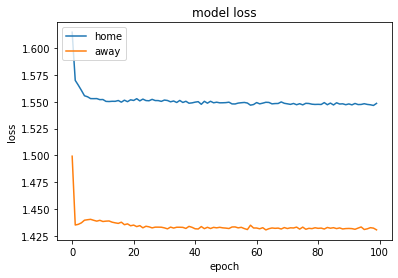

In [22]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['layer3_loss'])
plt.plot(history.history['layer3_1_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['home', 'away'], loc='upper left')
plt.show()

dict_keys(['loss', 'layer3_loss', 'layer3_1_loss', 'layer3_acc', 'layer3_1_acc'])


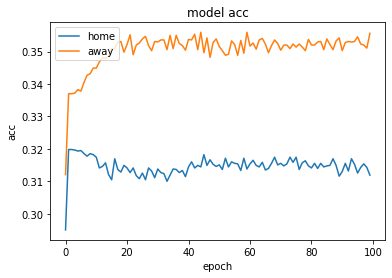

In [23]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['layer3_acc'])
plt.plot(history.history['layer3_1_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['home', 'away'], loc='upper left')
plt.show()

In [24]:
y_train_pred = model.predict(train_X02)
y_test_pred = model.predict(test_X02)

In [25]:
def pred_goal(arr, team):
    a=0
    retVal=np.empty((arr[0].size+1))
    games = int(arr[team].size / arr[team][1].size)
    for i in range(0, games):
        for j in range(0, (arr[team][i].size)):
            if a < arr[team][i][j]:
                a = arr[team][i][j]
                retVal[i] = j
        a = 0
    return retVal
        

In [26]:
predHome = pred_goal(y_test_pred, 0)
predAway = pred_goal(y_test_pred, 1)


In [27]:
def degree_diff(yoriginal,ypred):
    val = abs(yoriginal - ypred)
    switcher = {
        0: 1, # yoriginal = ypred
        1: 0.8, # diff of 1. Exple original 1 predicted 2 => 0.75
        2: 0.6,
        3: 0.4,
        4: 0.2, # diff of 4. Exple original 0 predicted 4
        5: 0
    }
    return switcher.get(val, 0)

In [28]:
quality_model_home_goals=0

for valorg,valpred in zip(yout1,predHome):
    quality_model_home_goals += degree_diff(valorg,valpred)
    
quality_model_home_goals = quality_model_home_goals / len(yout1)
print ("Quality model home goals TRAIN", quality_model_home_goals)

Quality model home goals TRAIN 0.7730113636363669


In [29]:
quality_model_away_goals=0

for valorg,valpred in zip(yout2,predAway):
    quality_model_away_goals += degree_diff(valorg,valpred)
    
quality_model_away_goals = quality_model_away_goals / len(yout2)
print ("Quality model away goals TRAIN", quality_model_away_goals)

Quality model away goals TRAIN 0.8346590909090928


In [30]:
final_quality = (quality_model_home_goals + quality_model_away_goals)/2
final_quality

0.8038352272727298